# Day 6: Target Engineering

## 🎯 Learning Objectives
- Different target definitions
- Multi-horizon targets
- Risk-adjusted targets

---

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

ticker = 'SPY'
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

data = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)

# Handle multi-level columns from yfinance
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

df = data.copy()
df['return'] = df['Close'].pct_change()
print(f"✅ Data: {len(df)} days")

✅ Data: 1254 days


In [2]:
# Target 1: Next-day return
df['target_1d'] = df['return'].shift(-1)

# Target 2: Next-day direction (binary)
df['target_dir'] = np.sign(df['target_1d']).map({1: 1, -1: 0, 0: 1})

# Target 3: Multi-day forward return
df['target_5d'] = df['Close'].shift(-5) / df['Close'] - 1
df['target_20d'] = df['Close'].shift(-20) / df['Close'] - 1

# Target 4: Triple barrier (from Week 6)
def triple_barrier(prices, upper=0.02, lower=-0.02, max_days=10):
    labels = []
    for i in range(len(prices) - max_days):
        entry = prices.iloc[i]
        for j in range(1, max_days + 1):
            ret = prices.iloc[i + j] / entry - 1
            if ret >= upper:
                labels.append(1)  # Take profit
                break
            elif ret <= lower:
                labels.append(0)  # Stop loss
                break
        else:
            labels.append(1 if prices.iloc[i + max_days] / entry - 1 > 0 else 0)
    return labels + [np.nan] * max_days

df['target_barrier'] = triple_barrier(df['Close'])

# Target 5: Risk-adjusted (Sharpe direction)
rolling_ret = df['return'].rolling(5).mean()
rolling_vol = df['return'].rolling(5).std()
df['target_sharpe'] = np.sign(rolling_ret.shift(-5) / rolling_vol.shift(-5))
df['target_sharpe'] = df['target_sharpe'].map({1: 1, -1: 0, 0: 1})

print("\n📊 Targets created")


📊 Targets created


In [3]:
# Analyze target distributions
print("\n" + "="*60)
print("TARGET ANALYSIS")
print("="*60)

print(f"\n1-day Return: mean={df['target_1d'].mean():.4%}, std={df['target_1d'].std():.4%}")
print(f"5-day Return: mean={df['target_5d'].mean():.4%}, std={df['target_5d'].std():.4%}")
print(f"20-day Return: mean={df['target_20d'].mean():.4%}, std={df['target_20d'].std():.4%}")

print(f"\nDirection (binary): {df['target_dir'].mean():.1%} positive")
print(f"Triple Barrier: {df['target_barrier'].dropna().mean():.1%} take-profit")
print(f"Sharpe Direction: {df['target_sharpe'].mean():.1%} positive")


TARGET ANALYSIS

1-day Return: mean=0.0575%, std=1.0784%
5-day Return: mean=0.2928%, std=2.2495%
20-day Return: mean=1.1441%, std=4.1534%

Direction (binary): 54.7% positive
Triple Barrier: 60.9% take-profit
Sharpe Direction: 60.9% positive


In [4]:
# Create features
df['ret_5d'] = df['return'].rolling(5).mean()
df['vol_20d'] = df['return'].rolling(20).std()
df['momentum'] = df['Close'].pct_change(20)
df['rsi'] = 100 - 100 / (1 + df['return'].clip(lower=0).rolling(14).mean() / 
                          (-df['return'].clip(upper=0).rolling(14).mean()))

feature_cols = ['ret_5d', 'vol_20d', 'momentum', 'rsi']
df_model = df.dropna()

In [5]:
# Compare targets
train_size = int(len(df_model) * 0.8)
train = df_model.iloc[:train_size]
test = df_model.iloc[train_size:]

X_train = train[feature_cols]
X_test = test[feature_cols]

targets_binary = ['target_dir', 'target_barrier', 'target_sharpe']

print("\n" + "="*60)
print("MODEL COMPARISON BY TARGET")
print("="*60)

for target in targets_binary:
    y_train = train[target]
    y_test = test[target]
    
    model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
    model.fit(X_train, y_train)
    acc = accuracy_score(y_test, model.predict(X_test))
    print(f"{target}: {acc:.1%}")


MODEL COMPARISON BY TARGET
target_dir: 54.3%
target_barrier: 63.0%
target_sharpe: 61.3%


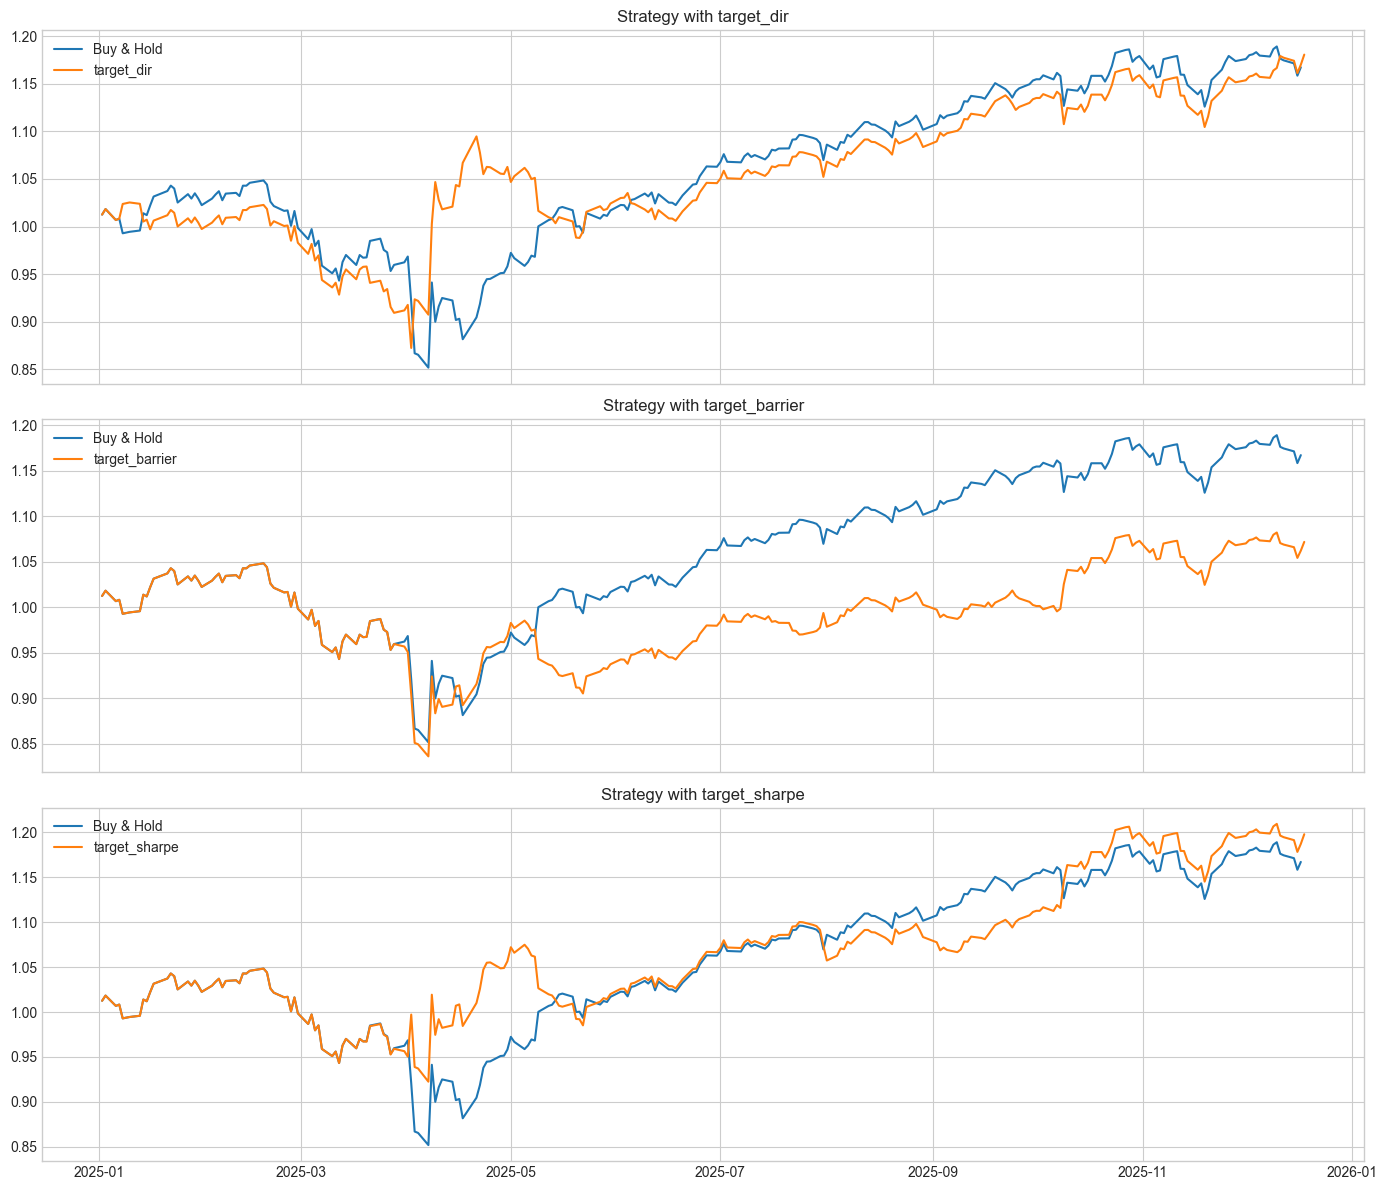

In [6]:
# Strategy comparison
fig, axes = plt.subplots(len(targets_binary), 1, figsize=(14, 12), sharex=True)

for ax, target in zip(axes, targets_binary):
    y_train = train[target]
    y_test = test[target]
    
    model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
    model.fit(X_train, y_train)
    
    result = test.copy()
    result['pred'] = model.predict(X_test)
    result['signal'] = result['pred'].map({1: 1, 0: -1})
    result['strategy_return'] = result['signal'] * result['return'].shift(-1)
    
    result = result.dropna()
    result['strategy_cum'] = (1 + result['strategy_return']).cumprod()
    result['buy_hold_cum'] = (1 + result['return'].shift(-1)).cumprod()
    
    ax.plot(result.index, result['buy_hold_cum'], label='Buy & Hold')
    ax.plot(result.index, result['strategy_cum'], label=target)
    ax.legend()
    ax.set_title(f'Strategy with {target}')

plt.tight_layout()
plt.show()

In [7]:
# Today's signals
print("\n" + "="*60)
print(f"📊 TODAY'S SIGNALS (Multiple Targets)")
print("="*60)
print(f"\nDate: {df_model.index[-1].strftime('%Y-%m-%d')}")

latest = df_model[feature_cols].iloc[[-1]]

for target in targets_binary:
    y_full = df_model[target]
    model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
    model.fit(df_model[feature_cols], y_full)
    pred = model.predict(latest)[0]
    print(f"\n{target}: {'📈 LONG' if pred == 1 else '📉 SHORT'}")


📊 TODAY'S SIGNALS (Multiple Targets)

Date: 2025-12-19

target_dir: 📈 LONG

target_barrier: 📈 LONG

target_sharpe: 📈 LONG


---
## 📅 Tomorrow: Week 11 Review